# Snake

In [401]:
from snake import re_normalize_possible_actions
from environments import *
import tensorflow as tf
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
from itertools import islice

## Environment definition

In [402]:
BOARD_SIZE=4

In [403]:
# region models
input = K.layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 3))
x = K.layers.Conv2D(32, (3, 3), padding="SAME", activation="linear", use_bias=False)(input)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(32, (3, 3), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.MaxPool2D(2)(x)

x = K.layers.Conv2D(32, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)
x = K.layers.GlobalAvgPool2D()(x)

encoder = K.Model(inputs=input, outputs=x)

dec = K.layers.Reshape((1, 1, -1))(x)
dec = K.layers.Conv2DTranspose(32, 2, activation=tf.nn.leaky_relu)(dec)
if BOARD_SIZE > 3:
    dec = K.layers.Conv2DTranspose(32, 2, activation=tf.nn.leaky_relu)(dec)
if BOARD_SIZE > 4:
    dec = K.layers.Conv2DTranspose(32, 2, activation=tf.nn.leaky_relu)(dec)
dec = K.layers.Conv2DTranspose(3, 2, activation=tf.nn.softmax)(dec)
decoder = K.Model(inputs=x, outputs=dec)

ae = K.models.Sequential([
    encoder,
    decoder
])

policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(policy)
policy = K.layers.Dense(4, activation=tf.nn.softmax)(policy)
agent = K.models.Model(inputs=input, outputs=policy)

# value = K.models.Sequential()
# value.add(K.layers.Flatten(input_shape=(BOARD_SIZE,BOARD_SIZE,4)))
# value.add(K.layers.Dense(256, activation='selu'))
# value.add(K.layers.Dense(256, activation='selu'))
# value.add(K.layers.Dense(1, activation='linear'))
vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(vf)
vf = K.layers.Dense(1, activation="linear")(vf)
value = K.models.Model(inputs=input, outputs=vf)

In [405]:
#agent.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/agent")
#value.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/value")

## Training

In [406]:
# env_ = ThreadEnvironment(1000, BOARD_SIZE, chunk_size=10, cpu_threads_multiplier=2)
# GAMMA = .99

In [407]:
agent.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/agent")
value.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/value")
ae.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/ae")

In [408]:
# optimizer_value = K.optimizers.Adam(1e-4)
# optimizer_agent = K.optimizers.Adam(1e-4)
# optimizer_autoencoder= K.optimizers.Adam(1e-5)

In [409]:
# avg_rewards = []
# ae_losses = []
# for iterations in trange(50):
#     state = env_.to_state()
#     #try:
#     if iterations % 25 == 0:
#         agent.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/agent")
#         value.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/value")
#         ae.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/ae")
#
#     with tf.GradientTape(persistent=True) as tape:
#         # calculate distributions of actions
#         original_probs = agent(
#             state
#         )
#         # remove actions that are not available
#         probs = re_normalize_possible_actions(
#             state,
#             original_probs
#         )
#         #sample actions
#         actions =  tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)
#
#         # MDP update
#         rewards = env_.move(actions)
#         new_state = env_.to_state()
#
#         # TD error
#         value_state = value(state)
#         td_error = tf.stop_gradient((rewards + GAMMA * value(new_state, training=False)) - value_state) * -1 # to do gradient ascend
#
#         # calculate the loss for both value and agent
#         actions_indexes = tf.concat((tf.range(actions.shape[0])[...,None] , actions), axis=-1)
#
#         # maybe introduce eligibility trace to simulate n-step td, to have longer dependencies
#         loss_agent = tf.stop_gradient(td_error) * tf.math.log(tf.gather_nd(probs, actions_indexes))
#         loss_value = tf.stop_gradient(td_error) * value_state
#         rec = ae(state)
#         loss = tf.reduce_sum(K.losses.CategoricalCrossentropy()(state, rec))
#
#     ae_losses.append(loss)
#
#     grad = tape.gradient(loss, ae.trainable_weights)
#     optimizer_autoencoder.apply_gradients(zip(grad, ae.trainable_weights))
#
#     # calculate gradient
#     gradient_agent = tape.gradient(loss_agent, agent.trainable_weights)
#     gradient_value = tape.gradient(loss_value, value.trainable_weights)
#     avg_rewards.append(tf.reduce_mean(rewards))
#
#     # update neural nets weights
#     optimizer_agent.apply_gradients(zip(gradient_agent, agent.trainable_weights))
#     optimizer_value.apply_gradients(zip(gradient_value, value.trainable_weights))
#
#     # just to be sure that long trainings do not end for some strange reason...
#     # except Exception as e:
#     #     print(e)
#     #     print("Resetting env")
#     #     env_ = ProcessEnvironment(200, BOARD_SIZE)

 ### Random policy reward

In [17]:
env_ = NumpyProcessEnvironment(100, BOARD_SIZE)
model_rewards = []

for _ in trange(1000):
    state = env_.to_state()
    original_probs = agent(
        state
    )
    probs = re_normalize_possible_actions(
        state,
        original_probs
    )
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)

    # MDP update
    rewards = env_.move(actions)
    model_rewards.append(tf.reduce_mean(rewards))

  0%|          | 0/1000 [00:00<?, ?it/s]

Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max


2022-12-23 22:11:35.383146: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 22:11:35.383318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-23 22:11:35.383665: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 22:11:35.383816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max


2022-12-23 22:11:37.408360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 22:11:37.408526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-23 22:11:37.414061: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 22:11:37.414201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max


2022-12-23 22:11:39.427959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 22:11:39.428113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-23 22:11:39.429098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 22:11:39.429304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

In [20]:
random_env_ = ThreadEnvironment(100, BOARD_SIZE)
random_rewards = []

for _ in trange(1000):
    state = random_env_.to_state()
    probs = re_normalize_possible_actions(
        state,
        tf.repeat([[.25]*4],100, axis=0)
    )
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)

    # MDP update
    rewards = random_env_.move(actions)
    random_rewards.append(tf.reduce_mean(rewards))

  0%|          | 0/1000 [00:00<?, ?it/s]

Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max


2022-12-23 22:17:09.546416: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 22:17:09.546555: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-23 22:17:09.547603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 22:17:09.547740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max


2022-12-23 22:17:11.517127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 22:17:11.517261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-23 22:17:11.518088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 22:17:11.518313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max


2022-12-23 22:17:13.490564: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 22:17:13.490722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-23 22:17:13.492813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 22:17:13.492966: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,


systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ml-apple-metal/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ml-apple-metal/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ml-apple-metal/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ml-apple-metal/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ml-apple-metal/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ml-apple-metal/lib/python3.9/multiprocessing/process.py", line 315, in _bootstr

KeyboardInterrupt: 

## Training evaluation

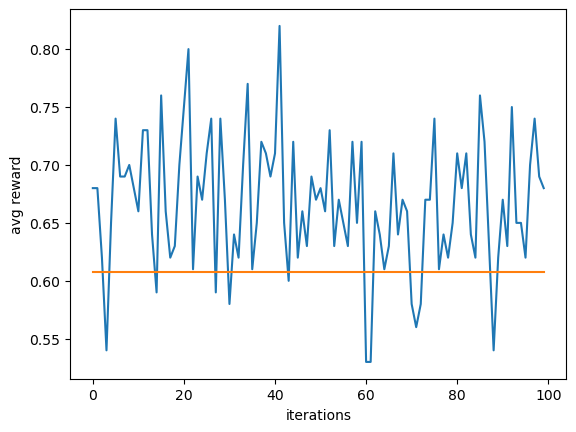

In [21]:
%matplotlib inline
plt.plot(np.array(model_rewards).reshape((-1, 10)).mean(axis=-1))
n = np.array(model_rewards).reshape((-1, 10)).mean(axis=-1).shape[0]
plt.plot(np.arange(0, n), np.repeat(np.mean(random_rewards), n))
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")

## Test (graphical simulation)

In [420]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [417]:
test_env = NumpyEnvironment(10,BOARD_SIZE)

In [418]:
def animate(_):
    state = test_env.to_state()
    original_probs = agent(
        state
    )
    probs = re_normalize_possible_actions(
        state,
        original_probs
    )
    log_probs = tf.math.log(tf.stop_gradient(probs))
    actions =  tf.random.categorical(log_probs, 1, dtype=tf.int32)
    test_env.move(actions)
    for board, image in zip(test_env.boards, images):
        image.set_data(board)
    return images

In [419]:
fig, axs = plt.subplots(2,5)
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, frames=3,interval=10)

<IPython.core.display.Javascript object>